In [ ]:
import nltk
from convokit import Corpus, download
import os
import json
import re
from collections import defaultdict, Counter
import csv
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

C:\Users\hofin\anaconda3\envs\bachelor_thesis\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


TransformerDecoderModel requires ML dependencies. Run 'pip install convokit[llm]' to install them.
UnslothUtteranceSimulatorModel requires ML dependencies. Run 'pip install convokit[llm]' to install them.


In [54]:
import json
import numpy as np

with open("data/results/20th_pass_annnotated_data.json", "r") as f:
    json_data = json.load(f)

# Example: if your docs are stored under "data"
json_records = json_data["data"]

import pandas as pd

df = pd.read_excel("examples.xlsx", sheet_name="Tabelle2")
df = df.replace({np.nan: None}) 

excel_texts = df["Text"].astype(str).tolist()

excel_category = df["Category"].astype(str).tolist()

# print(json_records["3"]["text"] == excel_texts[2])
# print(json_records["3"]["annotation"]["label"] == excel_category[2])

isMatchingList = []

for i in range(len(excel_category)):
    json_label = json_records[str(i+1)]["annotation"]["label"]
    excel_label = excel_category[i]
    
    if json_label == excel_label:
        isMatchingList.append(True)
    else:
        print(f"❌ Label mismatch at record {i+1}: JSON='{json_label}', Excel='{excel_label}'")
        print(f"   Text: {json_records[str(i+1)]['text']}")
        isMatchingList.append(False)

print(Counter(isMatchingList))



❌ Label mismatch at record 1: JSON='Stigmatizing', Excel='None'
   Text: Gotta look out for those foreign immigrants.
❌ Label mismatch at record 2: JSON='Dehumanizing', Excel='Stigmatizing'
   Text: christ, women are fucking stupid
❌ Label mismatch at record 7: JSON='Stigmatizing', Excel='None'
   Text: you mean, no reason to hate jews more than any other religion.
❌ Label mismatch at record 8: JSON='Stereotyping', Excel='Dehumanizing'
   Text: sandniggers are just as beautiful as any other women
❌ Label mismatch at record 9: JSON='Dehumanizing', Excel='Stigmatizing'
   Text: Fuck women and their socialistic scumshitlord ways of objectifying men.
❌ Label mismatch at record 13: JSON='Stereotyping', Excel='None'
   Text: What the fuck is wrong with people?
❌ Label mismatch at record 16: JSON='Stereotyping', Excel='None'
   Text: And feeling like some behind-enemy-lines spy going into the lesbian chat room!
❌ Label mismatch at record 17: JSON='Stereotyping', Excel='None'
   Text: You do k

In [35]:
# Method definitions
def load_dataset_dynamic(corpus, start_index, end_index):
    return Corpus(
        filename=download(corpus),
        backend="mem",
        utterance_start_index=start_index,
        utterance_end_index=end_index
    )

def load_dataset_to_memory(corpus_path):
    return Corpus(
        filename=corpus_path,
        backend="mem"
    )

def get_target_ids(corpus):
    target_ids = []
    
    othering_terms = [
        # Dehumanizing terms (animals, pests, disease metaphors)
        "animal", "beast", "savage", "barbaric", "subhuman", "primitive",
        "parasite", "vermin", "rat", "cockroach", "monster", "brute",
        "ape", "gorilla", "monkey", "dog", "pig", "swine", "goat",
        "bug", "leech", "tick", "lice", "maggot", "worm",
        "cancer", "tumor", "virus", "plague", "infection", "disease",

        # Moral judgment / worthlessness
        "scum", "trash", "filth", "worthless", "inferior", "degenerate",
        "lowlife", "unworthy", "unclean", "impure", "corrupt", "dirty",
        "disgusting", "vile", "evil", "wicked", "sinful", "cursed",
        "burden", "freeloader", "sponger",

        # Threatening / dangerous
        "dangerous", "violent", "aggressive", "hostile", "criminal", "thug",
        "deviant", "radical", "extremist", "fundamentalist", "terrorist",
        "predator", "rapist", "gangster", "invader", "occupier", "conqueror",
        "infiltrator", "threat",

        # Exclusion / separation
        "outsider", "intruder", "alien", "stranger", "foreigner", "enemy",
        "unwelcome", "illegal", "unwanted", "expat", "outcast", "undesirable",
        "colonizer", "settler",

        # Diminishing / infantilizing
        "ignorant", "backward", "naive", "uncivilized", "helpless",
        "weak", "stupid", "lazy", "immature", "childlike", "silly",
        "emotional", "hysterical", "irrational", "clueless",
        "brainwashed", "sheep", "puppet", "follower",

        # Religion & secular identities
        "atheists", "non-believers", "secular people",
        "buddhists", "buddhist people",
        "hindus", "hindu people",
        "christians", "christian people", "catholics", "protestants",
        "mormons", "evangelicals", "pagans", "satanists",
        "muslims", "islamic people", "islamists", "muzzies", "ragheads",
        "jews", "jewish people", "zionists", "orthodox jews",

        # Migration / nationality
        "immigrants", "migrants", "foreigners", "outsiders", "refugees",
        "asylum seekers", "expats", "nationals", "illegal aliens", "illegals",
        "invaders", "colonizers", "settlers",

        # Gender & women
        "women", "girls", "females", "ladies", "wives", "mothers",
        "bitches", "sluts", "whores", "feminists", "feminazis",

        # LGBTQ+
        "lgbtq", "gay", "gays", "lesbian", "lesbians",
        "bisexual", "transgender", "trans", "tranny", "trannies",
        "queer", "queers", "dyke", "dykes", "faggot", "faggots",
        "non-binary", "drag queens", "drag kings"
    ]
    
    # Pre-compile regex patterns
    patterns = [
        re.compile(r"(?i)(?<!\w)" + re.escape(term) + r"(?!\w)")
        for term in othering_terms
    ]

    for utt in corpus.iter_utterances():
        if any(p.search(utt.text) for p in patterns):
            target_ids.append(utt.id)

    return target_ids

    
def get_id_chain(corpus, target_id):
    chain = []
    utt = corpus.get_utterance(target_id)
    while utt is not None:
        chain.append(utt)
        utt = corpus.get_utterance(utt.reply_to) if utt.reply_to else None

    # reverse so it's from root → target
    chain = chain[::-1]
    return chain

def plot_wordcloud(chain, title):
    all_words = " ".join(u.text for u in chain).lower()
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [28]:
corpus = load_dataset_dynamic("reddit-corpus-small", 200, 1000)
target_ids = get_target_ids(corpus)

for target_id in target_ids:
    chain = get_id_chain(corpus, target_id)
    for u in chain:
        print(f"{u.id}")
    print("-----")



Dataset already exists at C:\Users\hofin\.convokit\saved-corpora\reddit-corpus-small
9e4xmr
-----
9fx7hj
-----
9hl2ta
-----
9c716m
e594ur8
-----
9c716m
e594ur8
e594yh7
e5951iv
e595bf1
e5amqqg
-----
9c716m
e594ur8
e594yh7
e5951iv
e595bf1
e5amqqg
e5as1ya
-----
9cfz10
e5at1yb
e5auqdp
e5av56e
e5b0iko
e5b4kml
-----
9crqp2
e5d0441
-----
9crqp2
e5d0441
e5d6nxi
-----
9d07z8
e5euds7
e5f3101
-----
9d07z8
e5euds7
e5ev7po
e5f1h0d
e5fbpe6
-----
9d07z8
e5ez20r
e5ez66d
-----
9d07z8
e5ez20r
e5f26z1
e5f55uh
-----
9dhcnh
e5i43bo
e5j7cgr
-----
9dhcnh
e5i43bo
e5j7cgr
e5k7x4d
-----
9dnnwe
e5jp30s
-----
9drpte
e5jq4bk
e5jr8vn
e5jrp5i
-----
9drpte
e5jq4bk
e5jr8vn
e5jrp5i
e5jxzff
-----
9drpte
e5jq4bk
e5k4nqw
-----
9drpte
e5jq4bk
e5k4nqw
e5kijtv
-----
9drpte
e5jq4bk
e5juy9m
e5kdi9q
e5lc8gv
-----
9drpte
e5jq4bk
e5jr8vn
e5jrp5i
e5lmzze
-----
9drpte
e5jq4bk
e5juy9m
e5kdi9q
e5lc8gv
e5lqybh
-----
9drpte
e5jq4bk
e5juy9m
e5kdi9q
e5lc8gv
e5lqybh
e5m0ria
-----
9drpte
e5jq4bk
e5juy9m
e5kdi9q
e5lc8gv
e5lqybh
e5m0ria
e5m1

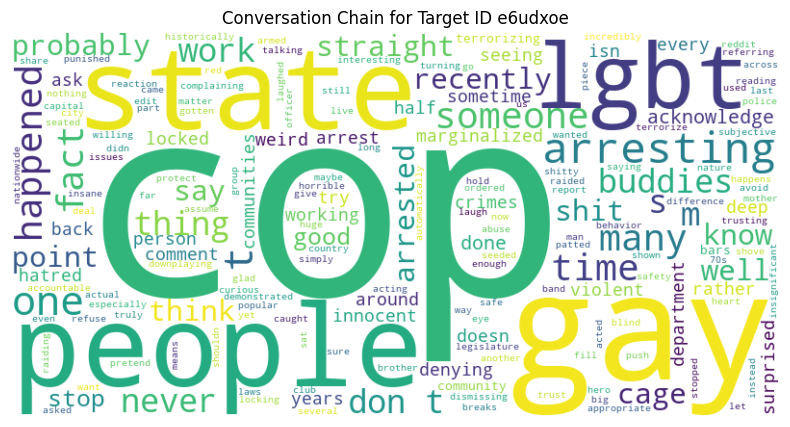

In [41]:
plot_wordcloud(get_id_chain(corpus, "e61bypg"), f"Conversation Chain for Target ID {'e6udxoe'}")

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="unsloth/Llama-3.3-70B-Instruct-bnb-4bit")
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe(messages)


c:\Users\hofin\anaconda3\envs\bachelor_thesis\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
The 8-bit optimizer is not available on your device, only available on CUDA for now.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

c:\Users\hofin\anaconda3\envs\bachelor_thesis\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hofin\.cache\huggingface\hub\models--unsloth--Llama-3.3-70B-Instruct-bnb-4bit. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00007-of-00008.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/4.75G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]